# Tests: Fixed Equation Forms
This notebook tests SHARE fitting given fixed programs (equation forms). Do the shape functions fit properly? 

## 0. Setup

In [1]:
import numpy as np 
import pandas as pd 
import torch

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")

from gplearn.gplearn._program import _Program 
import survshares.lightning # SBL Patch

%load_ext autoreload
%autoreload 2

In [ ]:
from gplearn.gplearn.model import ShapeNN
from gplearn.gplearn.fitness import mean_square_error
from gplearn.gplearn.functions import add2, sub2, mul2, div2, shape1
from sklearn.utils.validation import check_random_state


share_params = {
    "function_set": [add2, sub2, mul2, div2],
    "arities": {2: [add2, sub2, mul2, div2]},
    "init_depth": (2, 6),
    "init_method": "half and half",
    "n_features": 10,
    "const_range": (-1.0, 1.0),
    "metric": mean_square_error,
    "p_point_replace": 0.05,
    "parsimony_coefficient": 0.1,
    "optim_dict": {
        "alg": "adam",
        "lr": 1e-2,  # tuned automatically
        "max_n_epochs": 1000,
        "tol": 1e-3,
        "task": "regression",
        "device": "cpu",
        "batch_size": 1000,
        "shape_class": ShapeNN,
        "constructor_dict": {
            "n_hidden_layers": 5,
            "width": 10,
            "activation_name": "ELU",
        },
        "num_workers_dataloader": 0,
        "seed": 42,
        "checkpoint_folder": "results/checkpoints/test",
        "keep_models": False,
        "enable_progress_bar": False,
    },
    "random_state": check_random_state(415),
}

## 1. No Shape Functions

We first test a simple program with no shape functions as a sanity check.

In [ ]:
from sklearn.utils._testing import assert_array_almost_equal


def test_program():
    """Check executing the program works"""

    # Test for a small program
    test_gp = [mul2, div2, 8, 1, sub2, 9, 0.5]
    X = np.reshape(share_params["random_state"].uniform(size=50), (5, 10))
    gp = _Program(program=test_gp, **share_params)

    result = gp.execute(torch.Tensor(X))
    expected = (X[:, 8] / X[:, 1]) * (X[:, 9] - 0.5)
    assert_array_almost_equal(result, expected)


test_program()

## 2. Univariate Equations 

We check the shapes learned by fitting these univariate equations:

1. $y=x^2$
2. $y=x^3$
3. $y=x+5$
4. $y=x$ (thus $s(x) = x)$
5. $y=sin(x)$
6. $y=cos(exp(tan(x)))$ 

In [ ]:
%%capture
def test_shares_univariate():
    test_share = [shape1, 0]
    X_train, X_test = np.sort(np.random.rand(1000, 1), axis=0), np.sort(np.random.rand(1000, 1), axis=0)

    tests = {
        'y=x^2': lambda x: x ** 2,
        'y=x^3': lambda x: x ** 3,
        'y=x+5': lambda x: x + 5,
        'y=x': lambda x: x,
        'y=sin(x \pi)': lambda x: np.sin(x*np.pi),
        'y=cos(exp(tan(x)))': lambda x: np.cos(np.exp(np.tan(x))),
    }

    fig, axes = plt.subplots(2, 3, figsize=(10, 5))

    results = {}
    for ax, (name, func) in zip(axes.flatten(), tests.items()):
        y_train, y_test = func(X_train[:, 0]), func(X_test[:, 0])
        gp = _Program(program=test_share, **share_params)
        gp.raw_fitness(torch.Tensor(X_train), torch.Tensor(y_train), None)
        y_pred = gp.execute(torch.Tensor(X_test))
        results[name] = np.abs(y_pred - y_test).mean()

        ax.plot(X_test, y_pred, label='Predicted', color='blue')
        ax.plot(X_test, y_test, label='True', color='red')
        ax.set_title(f'${name}$ : $\pm {results[name]:.2f}$')


    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    return fig, results

fig_univariate, results_univariate = test_shares_univariate()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.02089296130854041
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_d9d38187-4e45-482f-85c7-3da33130f276.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_d9d38187-4e45-482f-85c7-3da33130f276.ckpt
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.05248074602497723
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_9a7b6c4c-a291-4f7e-a636-bb46f42f2960.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_9a7b6c4c-a291-4f7e-a636-bb46f42f2960.ckpt
G

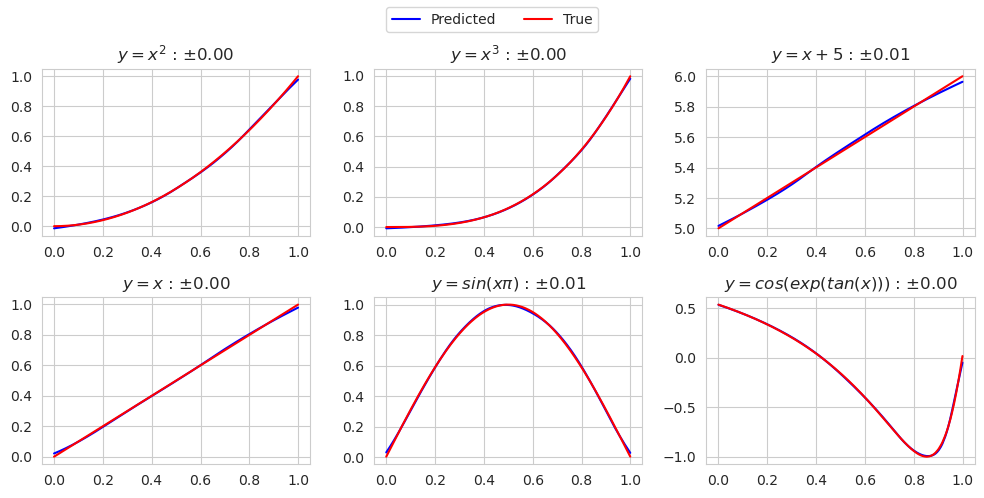

In [ ]:
fig_univariate

## 3. Multivariate Equations

Next we check the following equations with more variables:

1. $y=x_1 + x_2$ (thus $s(x) = x$)
2. $y=x_1^2 + x_2/2$
3. $y=s(x_1) + s(x_2) + s(x_3)$ (risk study)

We observe that the learned shape functions are vertically translated from the ground truth - this is expected.

In [12]:
%%capture
def test_shares_bivariate():
    test_share = [add2, shape1, 0, shape1, 1]
    X_train, X_test = np.random.rand(1000, 2), np.random.rand(1000, 2)

    tests = {
        'y=x_1 + x_2': [
            lambda x: x, 
            lambda x: x 
        ],
        'y=x_1^2 + sin(x_2 \pi)': [
            lambda x: x ** 2, 
            lambda x: np.sin(x * np.pi)
        ],
    }

    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    results = {}

    for ax_row, (name, functions) in zip(axes, tests.items()):
        y_train = functions[0](X_train[:, 0]) + functions[1](X_train[:, 1])
        y_test = functions[0](X_test[:, 0]) + functions[1](X_test[:, 1])

        gp = _Program(program=test_share, **share_params)
        gp.raw_fitness(torch.Tensor(X_train), torch.Tensor(y_train), None)
        y_pred = gp.execute(torch.Tensor(X_test))

        for i, (ax, func, shape, x_true) in enumerate(zip(ax_row, functions, gp.model.shape_functions, X_test.T)):
            x_true = np.sort(X_test[:, i])
            s_true = func(x_true)
            shape.to(torch.device('cpu'))
            with torch.no_grad():
                s_pred = shape(torch.Tensor(x_true)).flatten()

            result = np.corrcoef(s_pred.numpy(), s_true)[0, 1]
            results[f'{name}_{i}'] = result
            ax.plot(x_true, s_pred, label='Shape', color='blue')
            ax.plot(x_true, s_true, label='Ground Truth', color='red')
            ax.set_title(f'${name}: s_{i+1}$ : $Corr={result:.2f}$')

    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    return fig, results

fig_bivariate, results_bivariate = test_shares_bivariate()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LR finder stopped early after 95 steps due to diverging loss.
Learning rate set to 0.008317637711026709
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_42298a32-d8fa-4ee6-984f-87c5a3219fad.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_42298a32-d8fa-4ee6-984f-87c5a3219fad.ckpt
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LR finder stopped early after 96 steps due to diverging loss.
Learning rate set to 0.008317637711026709
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_15690361-4445-43bd-94a5-76d66b1945df.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_15690361-4445-43bd-94a5-76d66b1945df.ckpt

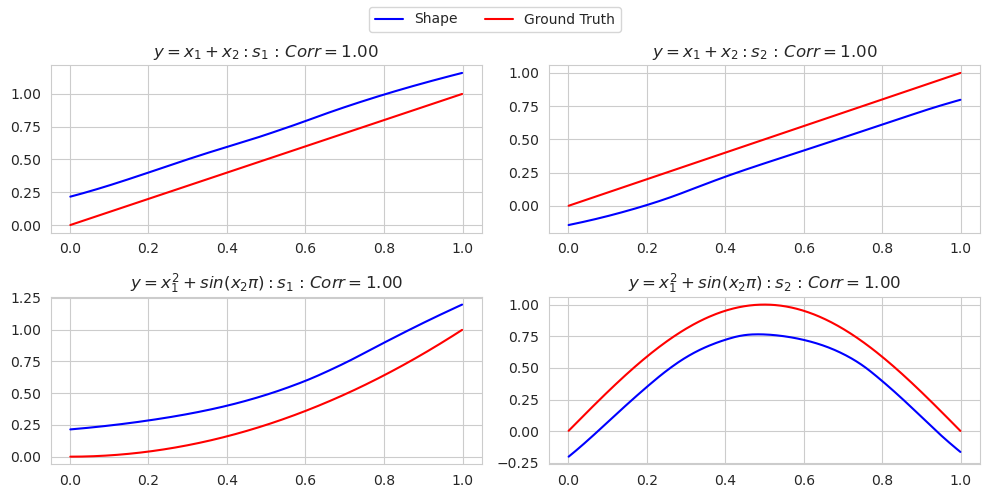

In [13]:
fig_bivariate

In [10]:
%%capture
from experiments.risk_scores_data import get_nodes_feature, get_age_feature, get_bmi_feature, generate_data
from sklearn.model_selection import train_test_split

def get_dataset():
    df = generate_data(1000, seed=42)
    X = df.drop(columns=['target']).values
    y = df['target'].values

    return train_test_split(X, y, test_size=0.2, random_state=42)

def test_shares_risk():
    test_share = [add2, add2, shape1, 0, shape1, 1, shape1, 2]
    X_train, X_test, y_train, y_test = get_dataset()

    features = {
        'nodes': (
            get_nodes_feature, 
            (0, 50, 1000)
        ),
        'age': (
            get_age_feature, 
            (45,70,1000)
        ),
        'bmi': (
            get_bmi_feature, 
            (17,45,1000)
        )
    }

    gp = _Program(program=test_share, **share_params)
    gp.raw_fitness(torch.Tensor(X_train), torch.Tensor(y_train), None)
    y_pred = gp.execute(torch.Tensor(X_test))
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    results = {}

    for i, (ax, shape, (name, (func, ranges))) in enumerate(zip(ax, gp.model.shape_functions, features.items())):
        x_true = np.linspace(*ranges)
        s_true = func()(x_true) 
        shape.to(torch.device('cpu'))
        with torch.no_grad():
            s_pred = shape(torch.Tensor(x_true)).flatten()

        result = np.corrcoef(s_pred.numpy(), s_true)[0, 1]
        results[f'{name}_{i}'] = result
        ax.plot(x_true, s_pred, label='Shape', color='blue')
        ax.plot(x_true, s_true, label='Ground Truth', color='red')
        ax.set_title(f'$s_{i}(${name}$)$ : Corr=${result:.2f}$')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig, results 

fig_risk, results_risk = test_shares_risk()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LR finder stopped early after 92 steps due to diverging loss.
Learning rate set to 0.04365158322401657
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_1c1145c5-3a36-4b94-b47b-60897311610e.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_1c1145c5-3a36-4b94-b47b-60897311610e.ckpt
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


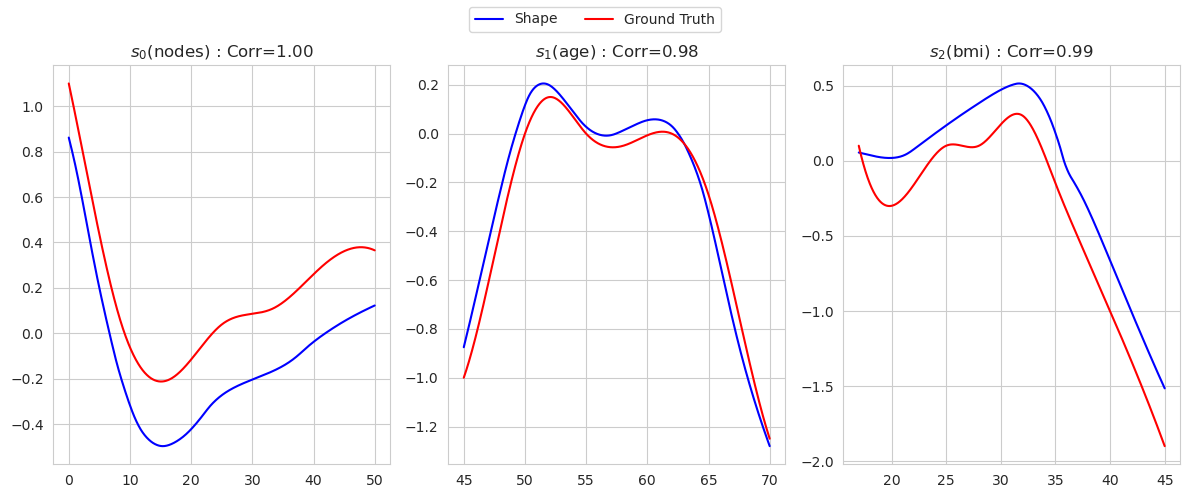

In [ ]:
fig_risk

## 4. Survival

Now we switch from a regression task to a survival task.

In [ ]:
%%capture
def test_shares_univariate():
    test_share = [shape1, 0]
    X_train, X_test = np.sort(np.random.rand(1000, 1), axis=0), np.sort(np.random.rand(1000, 1), axis=0)

    tests = {
        'y=x^2': lambda x: x ** 2,
        'y=x^3': lambda x: x ** 3,
        'y=x+5': lambda x: x + 5,
        'y=x': lambda x: x,
        'y=sin(x \pi)': lambda x: np.sin(x*np.pi),
        'y=cos(exp(tan(x)))': lambda x: np.cos(np.exp(np.tan(x))),
    }

    fig, axes = plt.subplots(2, 3, figsize=(10, 5))

    results = {}
    for ax, (name, func) in zip(axes.flatten(), tests.items()):
        y_train, y_test = func(X_train[:, 0]), func(X_test[:, 0])
        gp = _Program(program=test_share, **share_params)
        gp.raw_fitness(torch.Tensor(X_train), torch.Tensor(y_train), None)
        y_pred = gp.execute(torch.Tensor(X_test))
        results[name] = np.abs(y_pred - y_test).mean()

        ax.plot(X_test, y_pred, label='Predicted', color='blue')
        ax.plot(X_test, y_test, label='True', color='red')
        ax.set_title(f'${name}$ : $\pm {results[name]:.2f}$')


    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2)
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    return fig, results

fig_univariate, results_univariate = test_shares_univariate()

In [ ]:
from survshares.datasets import GBSG2
from sklearn.model_selection import train_test_split

dataset = GBSG2()
X, T, E = dataset.load()
X_train, X_test, T_train, T_test, E_train, E_test = train_test_split(X, T, E, test_size=0.2, random_state=42)
n_features = X.shape[1]

test_program_additive = [add2] * (n_features-1) + [elem for i in range(n_features) for elem in (shape1, i)]

gp = _Program(program=test_program_additive, **share_params)
gp.raw_fitness(X=torch.Tensor(X_train), y=torch.Tensor(T_train), sample_weight=torch.Tensor(E_train))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


add(add(add(add(add(add(add(shape(X0), shape(X1)), shape(X2)), shape(X3)), shape(X4)), shape(X5)), shape(X6)), shape(X7))


/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/home/paperspace/micromamba/envs/shares/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/paperspace/SurvSHAREs-dev/results/checkpoints/test/unknown exists and is not empty.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 97 steps due to diverging loss.
Learning rate set to 0.07585775750291836
Restoring states from the checkpoint path at data/lightning_logs/.lr_find_671667e1-e5f1-46af-8bc9-38545e0d79cf.ckpt
Restored all states from the checkpoint at data/lightning_logs/.lr_find_671667e1-e5f1-46af-8bc9-38545e0d79cf.ckpt


add(add(add(add(add(add(add(shape(X0), shape(X1)), shape(X2)), shape(X3)), shape(X4)), shape(X5)), shape(X6)), shape(X7))
add(add(add(add(add(add(add(shape(X0), shape(X1)), shape(X2)), shape(X3)), shape(X4)), shape(X5)), shape(X6)), shape(X7)) | raw_fitness: 421015.625


np.float32(421015.62)

{0: (np.int64(0), np.int64(1)), 1: (np.int64(21), np.int64(80)), 2: (np.int64(3), np.int64(120)), 3: (np.int64(1), np.int64(3)), 4: (np.int64(1), np.int64(51)), 5: (np.int64(0), np.int64(2380)), 6: (np.int64(0), np.int64(1144)), 7: (np.int64(0), np.int64(1))}


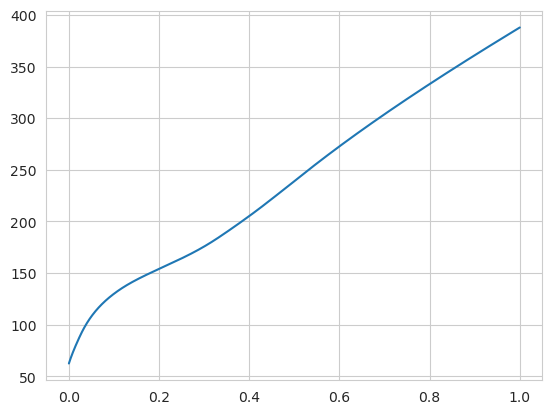

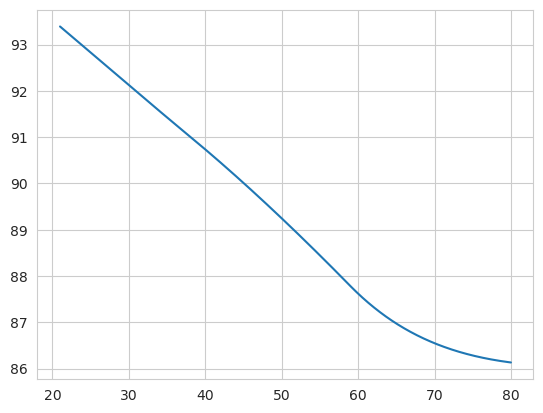

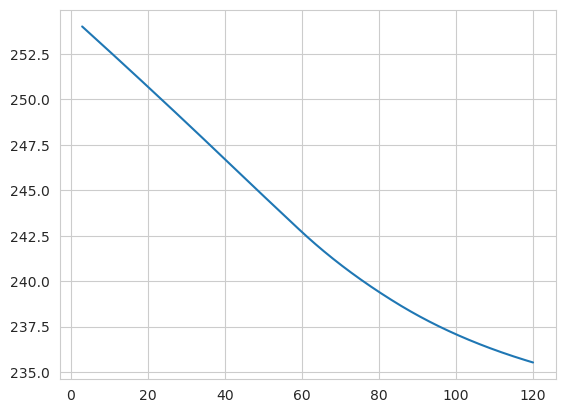

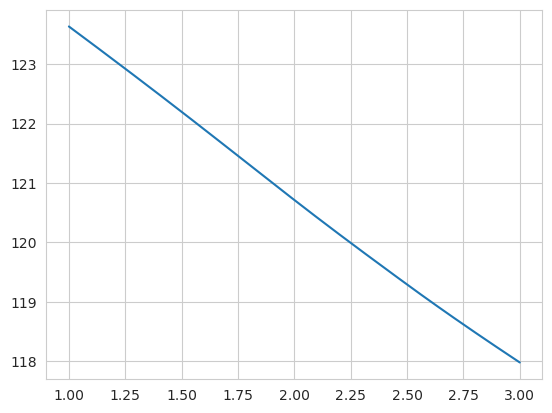

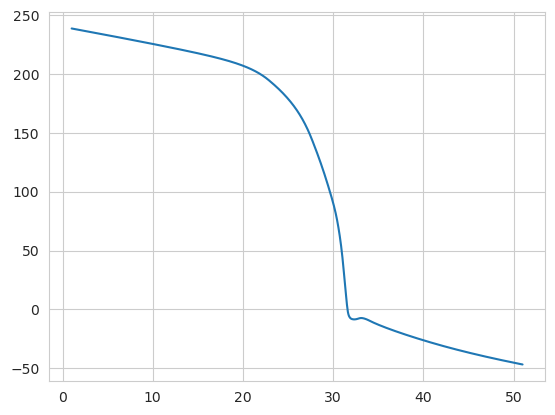

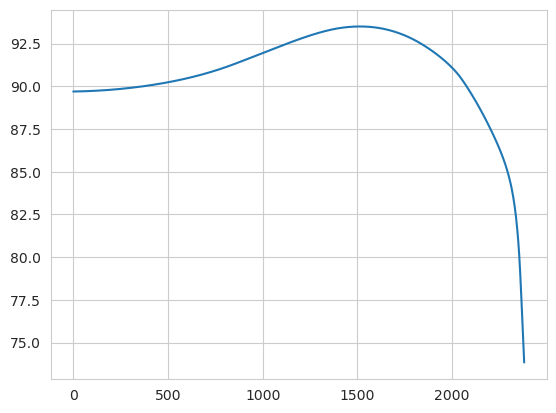

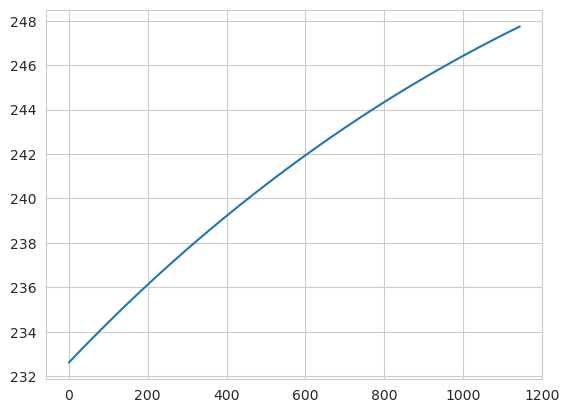

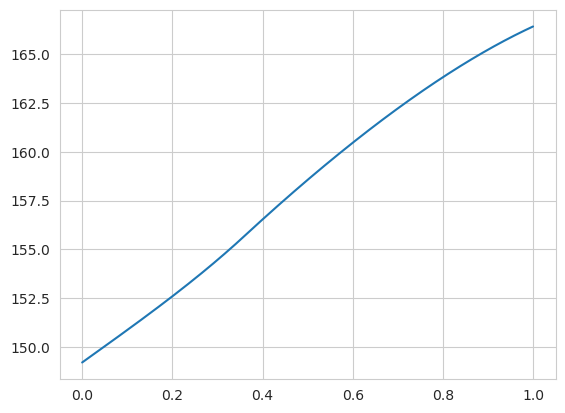

In [31]:
col_min_max = {i: (X[:, i].min(), X[:, i].max()) for i in range(X.shape[1])}
gp.plot_shape_functions(col_min_max, {})